In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 参考: https://docs.pytorch.org/docs/stable/generated/torch.nn.GRU.html
gru = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = gru(input, h0)

Epoch [10/50], Loss: 0.051826
Epoch [20/50], Loss: 0.018163
Epoch [30/50], Loss: 0.004395
Epoch [40/50], Loss: 0.000430
Epoch [50/50], Loss: 0.000358


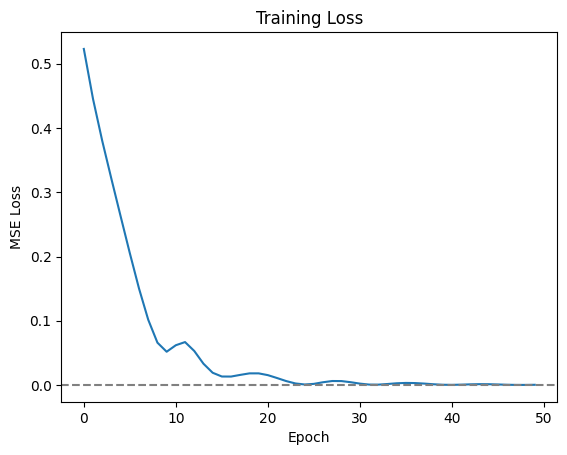

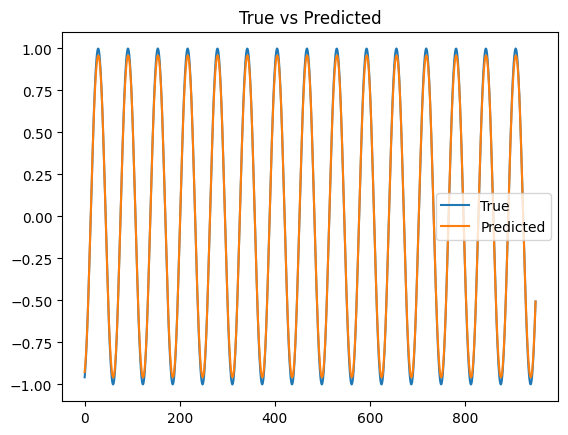

In [6]:
# ===== データ作成 =====
# sin波を作成
x = np.linspace(0, 100, 1000)
y = np.sin(x)

# シーケンスデータを作成（過去50ステップ→次の1ステップを予測）
seq_length = 50
dataX, dataY = [], []
for i in range(len(y) - seq_length):
    dataX.append(y[i : i + seq_length])
    dataY.append(y[i + seq_length])

dataX = torch.tensor(dataX, dtype=torch.float32).unsqueeze(-1)  # (N, seq_len, 1)
dataY = torch.tensor(dataY, dtype=torch.float32).unsqueeze(-1)  # (N, 1, 1)


# ===== モデル定義 =====
class GRUModel(nn.Module):
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = 20,
        num_layers: int = 1,
        output_size: int = 1,
    ) -> None:
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 最後の時刻の出力を使用
        return out


model = GRUModel()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ===== 学習 =====
epochs = 50
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(dataX)
    loss = loss_fn(output, dataY)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

# ===== 学習の様子 =====
plt.plot(losses)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# ===== 予測 =====
with torch.no_grad():
    pred = model(dataX).numpy()

plt.figure()
plt.plot(y[seq_length:], label="True")
plt.plot(pred.squeeze(), label="Predicted")
plt.legend()
plt.title("True vs Predicted")
plt.show()
